# Data processing
The dataset that used in this study originated from: [Battery Archive](https://www.batteryarchive.org/index.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import time
from tqdm import tqdm
import pickle
from filterpy.kalman import KalmanFilter
import datetime as datetime

In [2]:
filenames = listdir('Data/SNL_NCA/')

In [4]:
for cell_id in filenames:
    if ('NCA_25C_40-60' in cell_id) or ('NCA_25C_20-80' in cell_id):
        print(cell_id)

SNL_18650_NCA_25C_20-80_0.5-0.5C_a_cycle_data.csv
SNL_18650_NCA_25C_20-80_0.5-0.5C_a_timeseries.csv
SNL_18650_NCA_25C_20-80_0.5-0.5C_b_cycle_data.csv
SNL_18650_NCA_25C_20-80_0.5-0.5C_b_timeseries.csv
SNL_18650_NCA_25C_20-80_0.5-0.5C_c_cycle_data.csv
SNL_18650_NCA_25C_20-80_0.5-0.5C_c_timeseries.csv
SNL_18650_NCA_25C_20-80_0.5-0.5C_d_cycle_data.csv
SNL_18650_NCA_25C_20-80_0.5-0.5C_d_timeseries.csv
SNL_18650_NCA_25C_40-60_0.5-0.5C_a_cycle_data.csv
SNL_18650_NCA_25C_40-60_0.5-0.5C_a_timeseries.csv
SNL_18650_NCA_25C_40-60_0.5-0.5C_b_cycle_data.csv
SNL_18650_NCA_25C_40-60_0.5-0.5C_b_timeseries.csv


In [49]:
def load_from_raw_data(cell_id, meta_data, data, cap_upper_limit=3.2, cap_lower_limit=2, min_curr_lim = -1.7, min_voltage = 2.55):
    # If the time interval between two tests are more than 2 months the data will not be used
    if ('NCA_25C_40-60' in cell_id) or ('NCA_25C_20-80' in cell_id):
        capcity_ref = meta_data[(meta_data['Charge_Capacity (Ah)'] < cap_upper_limit) & (meta_data['Charge_Capacity (Ah)'] > cap_lower_limit) & (meta_data['Min_Current (A)'] > min_curr_lim) & (meta_data['Min_Voltage (V)'] < min_voltage)]
#         if 'NMC_25C_40-60' in cell_id:
#             diff_time_index = capcity_ref[capcity_ref['Start_Time'].diff() > pd.Timedelta("45 days")]['Cycle_Index']
#             capcity_ref = capcity_ref[capcity_ref['Cycle_Index'] < diff_time_index.item()]
        # Choose the average value of the consecutive capcity reference test
        pre_cycle_num = 0
        instant_cap = []
        charge_cap = []
        charge_cap_index = [10.0]
        for index, row in capcity_ref.iterrows():
            if row['Cycle_Index'] - pre_cycle_num < 8:
                instant_cap.append(row['Charge_Capacity (Ah)'])
                pre_cycle_num = row['Cycle_Index']
            else:
                charge_cap_index.append(row['Cycle_Index'])
                charge_cap.append(np.mean(instant_cap))
                instant_cap = []
                pre_cycle_num = row['Cycle_Index']
            if index == capcity_ref.iloc[-1].name:
                charge_cap.append(np.mean(instant_cap))
        output = dict()
        output['charge_capacity'] = charge_cap
        output['ref_cycle_index'] = np.array(charge_cap_index)-3
        # Select the charging time series data
        output['charge_profile'] = data[data['Cycle_Index'].isin(np.array(charge_cap_index)-3)]
    else:
        capcity_ref = meta_data[(meta_data['Charge_Capacity (Ah)'] < 3.2) & (meta_data['Charge_Capacity (Ah)'] > 2) & (meta_data['Max_Voltage (V)'] > 4.18)]
        if 
        charge_cap_index = capcity_ref.iloc[4::20, :]['Cycle_Index'].to_numpy()
        charge_cap = capcity_ref.iloc[4::20, :]['Charge_Capacity (Ah)'].to_numpy()
        output = dict(len(data['Voltage (V)']))
        output['charge_capacity'] = charge_cap
        output['ref_cycle_index'] = charge_cap_index
        # Select the charging time series data
        output['charge_profile'] = data[data['Cycle_Index'].isin(np.array(charge_cap_index))]
    return output

In [50]:
data = dict()
for i in tqdm(range(int(len(filenames)/2))):
    location = 'Data/SNL_NCA/'
    raw_meta = pd.read_csv(filepath_or_buffer=location+filenames[i*2], delimiter=',', parse_dates=['Start_Time'])
    raw_data = pd.read_csv(filepath_or_buffer=location+filenames[i*2+1], delimiter=',', parse_dates=['Date_Time'])
    data[f'{filenames[i*2][14:-15]}'] = load_from_raw_data(filenames[i*2], meta_data=raw_meta, data=raw_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.61it/s]


The cell cycling condition is: 15C_0-100_0.5-1C_a
Print cycle 369.0 information
49


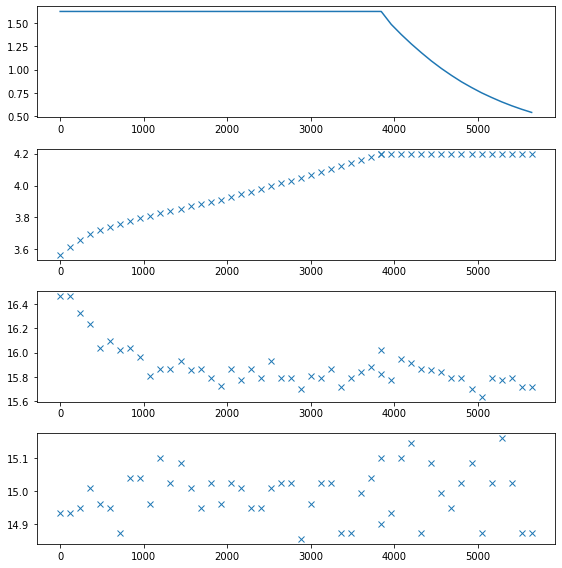

In [86]:
i = 18
cell_id = '15C_0-100_0.5-1C_a'
print(f"The cell cycling condition is: {cell_id}")
dataset = data[cell_id]['charge_profile']
# cycle_index = data[cell_id]['ref_cycle_index'][i]-3
cycle_index = data[cell_id]['ref_cycle_index'][i]
check_profile = dataset[dataset['Cycle_Index']==cycle_index]
print(f"Print cycle {cycle_index} information")
check_profile = check_profile[check_profile['Current (A)'] > 0]
fig, axs = plt.subplots(4, figsize=[8, 8])
axs[0].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Current (A)'])
axs[1].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Voltage (V)'], 'x')
axs[2].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Cell_Temperature (C)'], 'x')
axs[3].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Environment_Temperature (C)'], 'x')
fig.tight_layout()
print(len(check_profile['Voltage (V)']))

The cell cycling condition is: 15C_0-100_0.5-1C_a


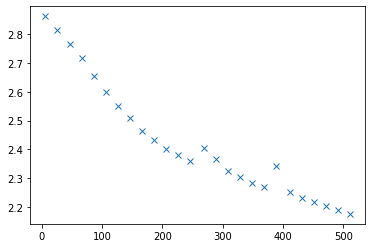

In [53]:
cell_id = list(data.keys())[0]
print(f"The cell cycling condition is: {cell_id}")
plt.plot(data[cell_id]['ref_cycle_index'], data[cell_id]['charge_capacity'], 'x')

In [87]:
# Check the time difference between the measurement is the same
for i in range(len(list(data.keys()))):
    cell_id = list(data.keys())[i]
    # print(f"The cell cycling condition is: {cell_id}")
    # fig, axs = plt.subplots(4, figsize=[8, 8])
    delete_index = []
    for index in range(len(data[cell_id]['ref_cycle_index'])):
        dataset = data[cell_id]['charge_profile']
        cycle_index = data[cell_id]['ref_cycle_index'][index]
        check_profile = dataset[dataset['Cycle_Index']==cycle_index]
        if (check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0]).diff().mean() < 20:
            delete_index.append(index)
    data[cell_id]['ref_cycle_index'] = np.delete(data[cell_id]['ref_cycle_index'], delete_index)
    data[cell_id]['charge_capacity'] = np.delete(data[cell_id]['charge_capacity'], delete_index)
    print(f"Cell {cell_id} {delete_index}th cycle has been removed")

Cell 15C_0-100_0.5-1C_a [19]th cycle has been removed
Cell 15C_0-100_0.5-1C_b [19, 32, 45]th cycle has been removed
Cell 15C_0-100_0.5-2C_a [19]th cycle has been removed
Cell 15C_0-100_0.5-2C_b [19]th cycle has been removed
Cell 25C_0-100_0.5-0.5C_a [0, 1, 2, 3, 4]th cycle has been removed
Cell 25C_0-100_0.5-0.5C_b [0, 1, 2, 3, 4, 5, 6]th cycle has been removed
Cell 25C_0-100_0.5-1C_a [19, 32]th cycle has been removed
Cell 25C_0-100_0.5-1C_b [19]th cycle has been removed
Cell 25C_0-100_0.5-1C_c [19]th cycle has been removed
Cell 25C_0-100_0.5-1C_d [19, 32]th cycle has been removed
Cell 25C_0-100_0.5-2C_a [19, 32]th cycle has been removed
Cell 25C_0-100_0.5-2C_b [19, 32]th cycle has been removed
Cell 25C_20-80_0.5-0.5C_a [0]th cycle has been removed
Cell 25C_20-80_0.5-0.5C_b [0]th cycle has been removed
Cell 25C_20-80_0.5-0.5C_c [0]th cycle has been removed
Cell 25C_20-80_0.5-0.5C_d [0]th cycle has been removed
Cell 25C_40-60_0.5-0.5C_a [0, 1]th cycle has been removed
Cell 25C_40-60_0.5

15C_0-100_0.5-1C_a ICA analysis


Text(0.5, 1.0, 'ICA analysis')

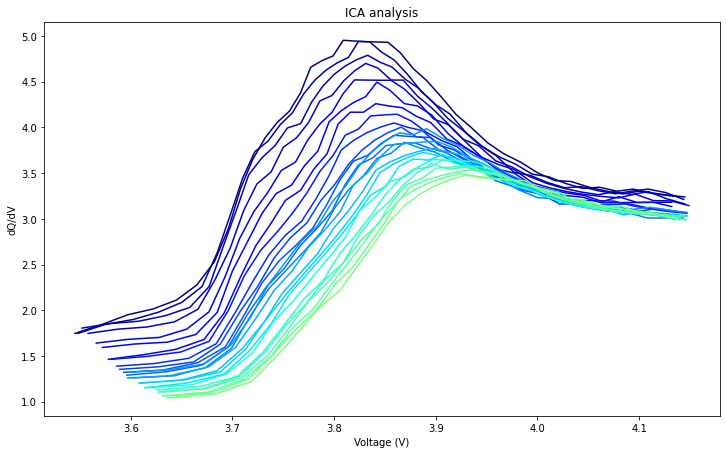

In [95]:
i = 0
cell_id = list(data.keys())[i]
print(f"{cell_id} ICA analysis")
plt.figure(figsize=[10, 6])
colors = plt.cm.jet(np.linspace(0,0.5,len(data[cell_id]['ref_cycle_index'])))
for i in range(len(data[cell_id]['ref_cycle_index'])):
    check_profile = data[cell_id]['charge_profile'][data[cell_id]['charge_profile']['Cycle_Index']==data[cell_id]['ref_cycle_index'][i]]
    check_profile = check_profile[check_profile['Current (A)']>0]
    dq_profile = check_profile[check_profile['Voltage (V)'] < 4.15]
    dq = dq_profile['Test_Time (s)'].diff().iloc[1:]*dq_profile['Current (A)'].iloc[1:] /3600
    dv = dq_profile['Voltage (V)'].diff().iloc[1:]
    dq_dv = dq / dv
    f = KalmanFilter (dim_x=1, dim_z=1)
    f.x = np.array([[np.array(dq_dv.iloc[0])]])
    f.F = np.array([[1]]) # State transition matrix
    f.H = np.array([[1]]) # Measurement function
    f.P = np.array([[1]]) # Initial covariance
    f.R = np.array([[1]]) # Measurement noise
    f.Q = np.array([[0.1]]) # process noise
    dq_dv_filtered, cov, _, _ = f.batch_filter(np.array(dq_dv))
    plt.plot(dq_profile['Voltage (V)'].iloc[1:], dq_dv_filtered.ravel(), color=colors[i], label=f"Cycle {int(data[cell_id]['ref_cycle_index'][i]-3)}")
# plt.legend()
plt.tight_layout()
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.title('ICA analysis')

The cell cycling condition is: 35C_0-100_0.5-2C_a


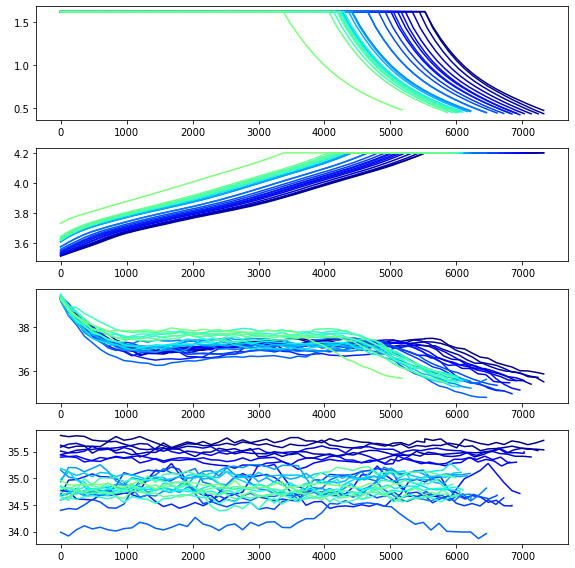

In [91]:
i = 22
cell_id = list(data.keys())[i]
print(f"The cell cycling condition is: {cell_id}")
colors = plt.cm.jet(np.linspace(0,0.5,len(data[cell_id]['ref_cycle_index'])))
fig, axs = plt.subplots(4, figsize=[8, 8])
for i in range(len(data[cell_id]['ref_cycle_index'])):
    dataset = data[cell_id]['charge_profile']
    cycle_index = data[cell_id]['ref_cycle_index'][i]
    check_profile = dataset[dataset['Cycle_Index']==cycle_index]
    dq_profile = check_profile[check_profile['Voltage (V)'] < 4.15]
    # print(f"Print cycle {cycle_index} information")
    check_profile = check_profile[check_profile['Current (A)'] > 0]
    axs[0].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Current (A)'], color=colors[i])
    axs[1].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Voltage (V)'], color=colors[i],)
    axs[2].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Cell_Temperature (C)'], color=colors[i],)
    axs[3].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Environment_Temperature (C)'], color=colors[i],)
fig.tight_layout()

The cell cycling condition is: 25C_0-100_0.5-0.5C_b
Print cycle 327.0 information


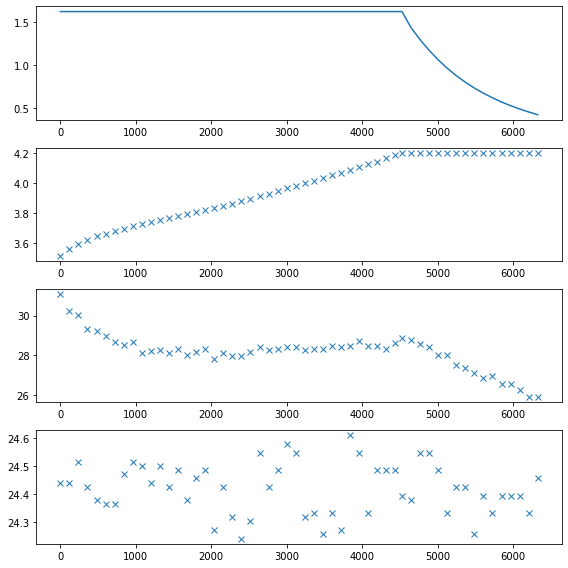

In [92]:
i = 5
cell_id = list(data.keys())[i]
print(f"The cell cycling condition is: {cell_id}")
dataset = data[cell_id]['charge_profile']
# cycle_index = data[cell_id]['ref_cycle_index'][i]-3
cycle_index = data[cell_id]['ref_cycle_index'][-7]
check_profile = dataset[dataset['Cycle_Index']==cycle_index]
print(f"Print cycle {cycle_index} information")
check_profile = check_profile[check_profile['Current (A)'] > 0]
fig, axs = plt.subplots(4, figsize=[8, 8])
axs[0].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Current (A)'])
axs[1].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Voltage (V)'], 'x')
axs[2].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Cell_Temperature (C)'], 'x')
axs[3].plot(check_profile['Test_Time (s)']-check_profile['Test_Time (s)'].iloc[0], check_profile['Environment_Temperature (C)'], 'x')
fig.tight_layout()

In [93]:
datetime.date.today().isoformat()

'2022-02-03'

In [94]:
# Save the data:
with open('Dataset/NCA_data_'+datetime.date.today().isoformat(), 'wb') as f:
    pickle.dump(data, f)